# Foodborne disease model

This is a test task for Longevity InTime AI powered company.

The idea is to train model to predict how many Illnesses will be produced from different cases which are depend of year, month, state, location, food, etc, and figure out which feature affects more on Illnesses.

The dataset was picked from https://www.kaggle.com/datasets/cdc/foodborne-diseases which was provided from CDC.

-------------

## Data Understanding and Data Preparation

-------------

In [1]:
import scipy
import dill

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
df = pd.read_csv('data/outbreaks.csv')
df.head(10)

Year    Month       State                Location  \
0  1998  January  California              Restaurant   
1  1998  January  California                     NaN   
2  1998  January  California              Restaurant   
3  1998  January  California              Restaurant   
4  1998  January  California  Private Home/Residence   
5  1998  January  California              Restaurant   
6  1998  January  California              Restaurant   
7  1998  January  California              Restaurant   
8  1998  January    Colorado              Restaurant   
9  1998  January    Colorado              Restaurant   

                                      Food Ingredient              Species  \
0                                      NaN        NaN                  NaN   
1                                  Custard        NaN                  NaN   
2                                      NaN        NaN                  NaN   
3                                Fish, Ahi        NaN      Scombroid toxin   
4        Lasagna, Unspecified; Eggs, Other        NaN  Salmonella enterica   
5                                      NaN        NaN      Shigella boydii   
6                                      NaN        NaN                  NaN   
7  Stuffing, Unspecified; Sandwich, Turkey        NaN  Salmonella enterica   
8                       Salad, Unspecified        NaN                Virus   
9                           Peppers, Chili        NaN                Virus   

  Serotype/Genotype     Status  Illnesses  Hospitalizations  Fatalities  
0               NaN        NaN         20               0.0         0.0  
1               NaN        NaN        112               0.0         0.0  
2               NaN        NaN         35               0.0         0.0  
3               NaN  Confirmed          4               0.0         0.0  
4       Enteritidis  Confirmed         26               3.0         0.0  
5               NaN  Confirmed         25               3.0         0.0  
6               NaN        NaN          8               0.0         0.0  
7       Enteritidis  Confirmed          4               3.0         0.0  
8               NaN  Suspected         21               NaN         NaN  
9               NaN  Suspected          3               NaN         0.0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19119 entries, 0 to 19118
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               19119 non-null  int64  
 1   Month              19119 non-null  object 
 2   State              19119 non-null  object 
 3   Location           16953 non-null  object 
 4   Food               10156 non-null  object 
 5   Ingredient         1876 non-null   object 
 6   Species            12500 non-null  object 
 7   Serotype/Genotype  3907 non-null   object 
 8   Status             12500 non-null  object 
 9   Illnesses          19119 non-null  int64  
 10  Hospitalizations   15494 non-null  float64
 11  Fatalities         15518 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 1.8+ MB


### Fill NaNs

Figure out how many NaN we have:

In [4]:
def calculate_nan(dataframe):
    for column in dataframe.columns:
        print(f'{column}: {100 * df[column].isna().sum() / len(df) :2.1f}%')

In [5]:
calculate_nan(df)

Year: 0.0%
Month: 0.0%
State: 0.0%
Location: 11.3%
Food: 46.9%
Ingredient: 90.2%
Species: 34.6%
Serotype/Genotype: 79.6%
Status: 34.6%
Illnesses: 0.0%
Hospitalizations: 19.0%
Fatalities: 18.8%


Check Location's values:

In [6]:
df['Location'].value_counts(dropna=False)

Restaurant                                                               10448
NaN                                                                       2166
Private Home/Residence                                                    1681
Catering Service                                                          1089
Banquet Facility                                                           367
                                                                         ...  
Private Home/Residence; Grocery Store; Child Daycare                         1
Restaurant; Private Home/Residence; Catering Service; Fair/Festival          1
Restaurant; Private Home/Residence; Grocery Store; Religious Facility        1
Child Daycare; Religious Facility                                            1
Hotel/Motel                                                                  1
Name: Location, Length: 162, dtype: int64

In this feature we already have 'Unknown' value, and amount of NaNs not so far from 'Unknown', so let's assign it to the NaNs.

In [7]:
df.loc[df['Location'].isna(), 'Location'] = 'Unknown'
df['Location'].value_counts(dropna=False)

Restaurant                                                               10448
Unknown                                                                   2521
Private Home/Residence                                                    1681
Catering Service                                                          1089
Banquet Facility                                                           367
                                                                         ...  
Private Home/Residence; Grocery Store; Child Daycare                         1
Restaurant; Private Home/Residence; Catering Service; Fair/Festival          1
Restaurant; Private Home/Residence; Grocery Store; Religious Facility        1
Child Daycare; Religious Facility                                            1
Hotel/Motel                                                                  1
Name: Location, Length: 161, dtype: int64

In [8]:
df['Serotype/Genotype'].value_counts(dropna=False)

NaN                                                                        15212
Unknown                                                                      690
Enteritidis                                                                  686
O157:H7                                                                      415
Typhimurium                                                                  282
                                                                           ...  
Typhimurium; Typhimurium var Cope                                              1
Aberdeen                                                                       1
Braenderup; Bovismorbificans; Javiana; Thompson; Rubislaw; Barranquilla        1
Rissen                                                                         1
IIaA17G2R2                                                                     1
Name: Serotype/Genotype, Length: 240, dtype: int64

We can assign NaNs to 'Unknown' too:

In [9]:
df.loc[df['Serotype/Genotype'].isna(), 'Serotype/Genotype'] = 'Unknown'
df['Serotype/Genotype'].value_counts(dropna=False)

# df = df.drop('Serotype/Genotype', axis=1)

Unknown                                                                    15902
Enteritidis                                                                  686
O157:H7                                                                      415
Typhimurium                                                                  282
Newport                                                                      169
                                                                           ...  
Typhimurium; Typhimurium var Cope                                              1
Aberdeen                                                                       1
Braenderup; Bovismorbificans; Javiana; Thompson; Rubislaw; Barranquilla        1
Rissen                                                                         1
IIaA17G2R2                                                                     1
Name: Serotype/Genotype, Length: 239, dtype: int64

In [10]:
df['Ingredient'].value_counts(dropna=False)

NaN                                                   17243
Fin Fish                                                190
Chicken                                                 179
Beef                                                    124
Egg                                                     119
                                                      ...  
Leafy Green; Leafy Green; Leafy Green; Leafy Green        1
Bread; Cheese; Turkey                                     1
Fruit, Unspecified; Melon                                 1
Fruit, Unspecified; Ice Cream                             1
Zucchini                                                  1
Name: Ingredient, Length: 382, dtype: int64

We don't have enough information to build model with Ingredient feature and it's difficult to recognize it from Food feature. Let's drop this column:

In [11]:
df = df.drop(columns='Ingredient')

In [12]:
df['Food'].value_counts(dropna=False)

NaN                                                   8963
Multiple Foods                                         206
Oysters, Raw                                           165
Ground Beef, Hamburger                                 127
Salad, Unspecified                                     118
                                                      ... 
Goat, Other                                              1
Chicken, Nuggets/Fingers; Coleslaw; Potato, Mashed       1
Sandwich, Club; Potato Salad                             1
Milk, 2% Milk Pasteurized                                1
Cookies, Chocolate Chip                                  1
Name: Food, Length: 3128, dtype: int64

We can't remove Food argument from model about Foodborne disease. So let's fill nan's with 'unknown' value.

In [13]:
df.loc[df['Food'].isna(), 'Food'] = 'Unknown'
df['Food'].value_counts(dropna=False)

Unknown                                               8963
Multiple Foods                                         206
Oysters, Raw                                           165
Ground Beef, Hamburger                                 127
Salad, Unspecified                                     118
                                                      ... 
Goat, Other                                              1
Chicken, Nuggets/Fingers; Coleslaw; Potato, Mashed       1
Sandwich, Club; Potato Salad                             1
Milk, 2% Milk Pasteurized                                1
Cookies, Chocolate Chip                                  1
Name: Food, Length: 3128, dtype: int64

In [14]:
df['Species'].value_counts(dropna=False)

NaN                                                                  6619
Norovirus genogroup I                                                2744
Salmonella enterica                                                  2303
Norovirus genogroup II                                               1424
Norovirus unknown                                                     790
                                                                     ... 
Bacillus other                                                          1
Bacillus cereus; Clostridium perfringens; Bacterium                     1
Staphylococcus other                                                    1
Salmonella enterica; Clostridium perfringens; Salmonella enterica       1
Shigella sonnei; Campylobacter jejuni                                   1
Name: Species, Length: 202, dtype: int64

Repeat it with Species in the same way:

In [15]:
df.loc[df['Species'].isna(), 'Species'] = 'Unknown'
df['Species'].value_counts(dropna=False)

Unknown                                                6635
Norovirus genogroup I                                  2744
Salmonella enterica                                    2303
Norovirus genogroup II                                 1424
Norovirus unknown                                       790
                                                       ... 
Bacillus cereus; Clostridium perfringens; Bacterium       1
Staphylococcus other                                      1
Campylobacter jejuni; Bacillus cereus                     1
Clostridium perfringens; Streptococcus group A            1
Shigella sonnei; Campylobacter jejuni                     1
Name: Species, Length: 201, dtype: int64

In [16]:
df['Status'].value_counts(dropna=False)

Confirmed                                                                                                                                        7909
NaN                                                                                                                                              6619
Suspected                                                                                                                                        4068
Suspected; Suspected                                                                                                                              310
Confirmed; Confirmed                                                                                                                              133
Confirmed; Suspected                                                                                                                               32
Confirmed; Confirmed; Confirmed                                                                     

We see that there are only 2 states for Status: Confirmed and Suspected. Also it contains sequences for different Species. We will explode it later, but now let's drop all nans to be sure that in these cases:

In [17]:
df.loc[df['Status'].isna(), 'Status'] = 'Unknown'
df['Status'].value_counts(dropna=False)

Confirmed                                                                                                                                        7909
Unknown                                                                                                                                          6619
Suspected                                                                                                                                        4068
Suspected; Suspected                                                                                                                              310
Confirmed; Confirmed                                                                                                                              133
Confirmed; Suspected                                                                                                                               32
Confirmed; Confirmed; Confirmed                                                                     

We will predict Illnesses without information of Hospitalizations and Fatalities

In [18]:
df = df.drop(['Hospitalizations', 'Fatalities'], axis=1)
df.head(10)

Year    Month       State                Location  \
0  1998  January  California              Restaurant   
1  1998  January  California                 Unknown   
2  1998  January  California              Restaurant   
3  1998  January  California              Restaurant   
4  1998  January  California  Private Home/Residence   
5  1998  January  California              Restaurant   
6  1998  January  California              Restaurant   
7  1998  January  California              Restaurant   
8  1998  January    Colorado              Restaurant   
9  1998  January    Colorado              Restaurant   

                                      Food              Species  \
0                                  Unknown              Unknown   
1                                  Custard              Unknown   
2                                  Unknown              Unknown   
3                                Fish, Ahi      Scombroid toxin   
4        Lasagna, Unspecified; Eggs, Other  Salmonella enterica   
5                                  Unknown      Shigella boydii   
6                                  Unknown              Unknown   
7  Stuffing, Unspecified; Sandwich, Turkey  Salmonella enterica   
8                       Salad, Unspecified                Virus   
9                           Peppers, Chili                Virus   

  Serotype/Genotype     Status  Illnesses  
0           Unknown    Unknown         20  
1           Unknown    Unknown        112  
2           Unknown    Unknown         35  
3           Unknown  Confirmed          4  
4       Enteritidis  Confirmed         26  
5           Unknown  Confirmed         25  
6           Unknown    Unknown          8  
7       Enteritidis  Confirmed          4  
8           Unknown  Suspected         21  
9           Unknown  Suspected          3

In [19]:
calculate_nan(df)

Year: 0.0%
Month: 0.0%
State: 0.0%
Location: 0.0%
Food: 0.0%
Species: 0.0%
Serotype/Genotype: 0.0%
Status: 0.0%
Illnesses: 0.0%


Now there're no NaNs in dataframe.

### Explode subvalues

In [20]:
df_test = df.copy()
df_test.head(5)

Year    Month       State                Location  \
0  1998  January  California              Restaurant   
1  1998  January  California                 Unknown   
2  1998  January  California              Restaurant   
3  1998  January  California              Restaurant   
4  1998  January  California  Private Home/Residence   

                                Food              Species Serotype/Genotype  \
0                            Unknown              Unknown           Unknown   
1                            Custard              Unknown           Unknown   
2                            Unknown              Unknown           Unknown   
3                          Fish, Ahi      Scombroid toxin           Unknown   
4  Lasagna, Unspecified; Eggs, Other  Salmonella enterica       Enteritidis   

      Status  Illnesses  
0    Unknown         20  
1    Unknown        112  
2    Unknown         35  
3  Confirmed          4  
4  Confirmed         26

In [21]:
# generate lists
feature_to_explode = ['Food', 'Species', 'Status', 'Location', 'Serotype/Genotype']

for feature in feature_to_explode:
    df_test[feature] = df_test[feature].astype(str).apply(lambda x: x.split(sep=';'))

df_test

Year     Month       State                                 Location  \
0      1998   January  California                             [Restaurant]   
1      1998   January  California                                [Unknown]   
2      1998   January  California                             [Restaurant]   
3      1998   January  California                             [Restaurant]   
4      1998   January  California                 [Private Home/Residence]   
...     ...       ...         ...                                      ...   
19114  2015  December   Wisconsin                             [Restaurant]   
19115  2015  December   Wisconsin                 [Private Home/Residence]   
19116  2015  December   Wisconsin  [Nursing Home/Assisted Living Facility]   
19117  2015  December   Wisconsin                   [Fast Food Restaurant]   
19118  2015  December     Wyoming                                [Unknown]   

                                       Food                   Species  \
0                                 [Unknown]                 [Unknown]   
1                                 [Custard]                 [Unknown]   
2                                 [Unknown]                 [Unknown]   
3                               [Fish, Ahi]         [Scombroid toxin]   
4      [Lasagna, Unspecified,  Eggs, Other]     [Salmonella enterica]   
...                                     ...                       ...   
19114                             [Unknown]  [Norovirus genogroup II]   
19115                               [Salsa]  [Norovirus genogroup II]   
19116                             [Unknown]  [Norovirus genogroup II]   
19117                             [Unknown]  [Norovirus genogroup II]   
19118                             [Unknown]                 [Unknown]   

              Serotype/Genotype       Status  Illnesses  
0                     [Unknown]    [Unknown]         20  
1                     [Unknown]    [Unknown]        112  
2                     [Unknown]    [Unknown]         35  
3                     [Unknown]  [Confirmed]          4  
4                 [Enteritidis]  [Confirmed]         26  
...                         ...          ...        ...  
19114                  [GII_14]  [Confirmed]          4  
19115                   [GII_2]  [Confirmed]         16  
19116  [GII_17 Kawasaki (2014)]  [Confirmed]         43  
19117                   [GII_2]  [Confirmed]          5  
19118                 [Unknown]    [Unknown]          3  

[19119 rows x 9 columns]

In [22]:
# explode each column separately
for feature in feature_to_explode:
    df_test = df_test.explode(column=feature)
    df_test[feature] = df_test[feature].str.strip()

In [23]:
df_test.head(20)

Year    Month       State                Location  \
0   1998  January  California              Restaurant   
1   1998  January  California                 Unknown   
2   1998  January  California              Restaurant   
3   1998  January  California              Restaurant   
4   1998  January  California  Private Home/Residence   
4   1998  January  California  Private Home/Residence   
5   1998  January  California              Restaurant   
6   1998  January  California              Restaurant   
7   1998  January  California              Restaurant   
7   1998  January  California              Restaurant   
8   1998  January    Colorado              Restaurant   
9   1998  January    Colorado              Restaurant   
10  1998  January    Colorado           Grocery Store   
11  1998  January    Colorado              Restaurant   
12  1998  January    Colorado  Private Home/Residence   
13  1998  January     Florida              Restaurant   
14  1998  January     Florida              Restaurant   
15  1998  January     Florida              Restaurant   
16  1998  January     Florida              Restaurant   
17  1998  January     Florida              Restaurant   

                         Food                  Species Serotype/Genotype  \
0                     Unknown                  Unknown           Unknown   
1                     Custard                  Unknown           Unknown   
2                     Unknown                  Unknown           Unknown   
3                   Fish, Ahi          Scombroid toxin           Unknown   
4        Lasagna, Unspecified      Salmonella enterica       Enteritidis   
4                 Eggs, Other      Salmonella enterica       Enteritidis   
5                     Unknown          Shigella boydii           Unknown   
6                     Unknown                  Unknown           Unknown   
7       Stuffing, Unspecified      Salmonella enterica       Enteritidis   
7            Sandwich, Turkey      Salmonella enterica       Enteritidis   
8          Salad, Unspecified                    Virus           Unknown   
9              Peppers, Chili                    Virus           Unknown   
10                    Unknown                    Virus           Unknown   
11                    Unknown                    Virus           Unknown   
12                    Unknown                    Virus           Unknown   
13              Chicken Salad                  Unknown           Unknown   
14          Hot Dog, Kielbasa                  Unknown           Unknown   
15  Ethnic Style, Unspecified  Clostridium perfringens           Unknown   
16                Greek Salad    Norovirus genogroup I           Unknown   
17  Ground Beef, Cheeseburger    Staphylococcus aureus           Unknown   

       Status  Illnesses  
0     Unknown         20  
1     Unknown        112  
2     Unknown         35  
3   Confirmed          4  
4   Confirmed         26  
4   Confirmed         26  
5   Confirmed         25  
6     Unknown          8  
7   Confirmed          4  
7   Confirmed          4  
8   Suspected         21  
9   Suspected          3  
10  Suspected          8  
11  Suspected         28  
12  Suspected         10  
13    Unknown          2  
14    Unknown          3  
15  Suspected          3  
16  Suspected          2  
17  Suspected          2

-------------

## Feature engineering

----------------

In [24]:
# allocate target
X = df_test.drop(['Illnesses'], axis=1)
y = df_test['Illnesses']

In [25]:
# save test sample in json
sample = X.sample(10).rename(columns={'Serotype/Genotype': 'Serotype_Genotype'})
sample.reset_index(inplace=True, names='id')

for i in range(5):
    # sample.iloc[i].to_json(f'data/test_sample_{i}.json', orient='records')
    json_str = sample.iloc[i].to_json().replace('\\/', '/')
    with open(f'data/test_sample_{i}.json', 'w') as file:
        file.write(json_str)
    
sample

id  Year     Month        State                Location  \
0  12854  2008      June      Florida                 Unknown   
1   8731  2004   October    Minnesota  Private Home/Residence   
2   6777  2003  February  Mississippi              Restaurant   
3   5804  2002       May     New York           Fair/Festival   
4  17080  2013    August    Minnesota           Fair/Festival   
5  10217  2006     March     Illinois                 Unknown   
6   2697  2000   January     Maryland              Restaurant   
7  17080  2013    August    Minnesota           Fair/Festival   
8   5583  2002     March     Virginia              Restaurant   
9  17080  2013    August    Minnesota           Fair/Festival   

                            Food                Species Serotype_Genotype  \
0     Fish, Grouper, Unspecified             Ciguatoxin           Unknown   
1  Mixed Vegetables, Unspecified  Norovirus genogroup I           Unknown   
2                        Unknown                Unknown           Unknown   
3          Sandwich, Unspecified                Unknown           Unknown   
4                     Guinea Pig    Salmonella enterica            Uganda   
5    Other Cheese, Unpasteurized    Salmonella enterica           Newport   
6                     Crab Cakes    Salmonella enterica       Enteritidis   
7                           Corn    Salmonella enterica           Chailey   
8                        Unknown  Norovirus genogroup I           Unknown   
9                     Guinea Pig    Salmonella enterica       Typhimurium   

      Status  
0  Confirmed  
1  Confirmed  
2    Unknown  
3    Unknown  
4  Confirmed  
5  Confirmed  
6  Confirmed  
7  Confirmed  
8  Confirmed  
9  Suspected

In [26]:
# check how many uniques in each column
for feature in X.columns:
    print(f'{feature}: {X[feature].nunique()}')

Year: 18
Month: 12
State: 55
Location: 22
Food: 1724
Species: 90
Serotype/Genotype: 176
Status: 3


In [27]:
# encode features by ohe
ohe = OneHotEncoder(sparse_output=False, max_categories=10)
X_encoded = pd.DataFrame(ohe.fit_transform(X), columns=ohe.get_feature_names_out(), index=X.index)
X_encoded

Year_1998  Year_1999  Year_2000  Year_2001  Year_2002  Year_2003  \
0            1.0        0.0        0.0        0.0        0.0        0.0   
1            1.0        0.0        0.0        0.0        0.0        0.0   
2            1.0        0.0        0.0        0.0        0.0        0.0   
3            1.0        0.0        0.0        0.0        0.0        0.0   
4            1.0        0.0        0.0        0.0        0.0        0.0   
...          ...        ...        ...        ...        ...        ...   
19114        0.0        0.0        0.0        0.0        0.0        0.0   
19115        0.0        0.0        0.0        0.0        0.0        0.0   
19116        0.0        0.0        0.0        0.0        0.0        0.0   
19117        0.0        0.0        0.0        0.0        0.0        0.0   
19118        0.0        0.0        0.0        0.0        0.0        0.0   

       Year_2004  Year_2006  Year_2013  Year_infrequent_sklearn  ...  \
0            0.0        0.0        0.0                      0.0  ...   
1            0.0        0.0        0.0                      0.0  ...   
2            0.0        0.0        0.0                      0.0  ...   
3            0.0        0.0        0.0                      0.0  ...   
4            0.0        0.0        0.0                      0.0  ...   
...          ...        ...        ...                      ...  ...   
19114        0.0        0.0        0.0                      1.0  ...   
19115        0.0        0.0        0.0                      1.0  ...   
19116        0.0        0.0        0.0                      1.0  ...   
19117        0.0        0.0        0.0                      1.0  ...   
19118        0.0        0.0        0.0                      1.0  ...   

       Serotype/Genotype_I 4,[5],12:i:-  Serotype/Genotype_Infantis  \
0                                   0.0                         0.0   
1                                   0.0                         0.0   
2                                   0.0                         0.0   
3                                   0.0                         0.0   
4                                   0.0                         0.0   
...                                 ...                         ...   
19114                               0.0                         0.0   
19115                               0.0                         0.0   
19116                               0.0                         0.0   
19117                               0.0                         0.0   
19118                               0.0                         0.0   

       Serotype/Genotype_O157:H7  Serotype/Genotype_Typhimurium  \
0                            0.0                            0.0   
1                            0.0                            0.0   
2                            0.0                            0.0   
3                            0.0                            0.0   
4                            0.0                            0.0   
...                          ...                            ...   
19114                        0.0                            0.0   
19115                        0.0                            0.0   
19116                        0.0                            0.0   
19117                        0.0                            0.0   
19118                        0.0                            0.0   

       Serotype/Genotype_Uganda  Serotype/Genotype_Unknown  \
0                           0.0                        1.0   
1                           0.0                        1.0   
2                           0.0                        1.0   
3                           0.0                        1.0   
4                           0.0                        0.0   
...                         ...                        ...   
19114                       0.0                        0.0   
19115                       0.0                        0.0   
19116                    

In [28]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=12)

-------

## Modeling

-------

For 1st model we'll try linear regression:

In [29]:
# initialize scoring list
scores = []
times = []

In [30]:
# define and train model
model1 = LinearRegression()

In [31]:
# training model
start = datetime.now()
model1.fit(X_train, y_train)
time = datetime.now() - start

scores.append(r2_score(y_test, model1.predict(X_test)))
times.append(time.seconds + time.microseconds*1e-6)

In [32]:
print(f'MSE on train: {mean_squared_error(y_train, model1.predict(X_train))}\n'
      f'MSE on test: {mean_squared_error(y_test, model1.predict(X_test))}\n'
      f'RMSE on train: {mean_squared_error(y_train, model1.predict(X_train), squared=False)}\n'
      f'RMSE on test: {mean_squared_error(y_test, model1.predict(X_test), squared=False)}\n'
      f'R2-score on train: {r2_score(y_train, model1.predict(X_train))}\n'
      f'R2-score on test: {r2_score(y_test, model1.predict(X_test))}\n')

MSE on train: 2694.6405298917516
MSE on test: 2762.696338897937
RMSE on train: 51.90992708424615
RMSE on test: 52.561357848688964
R2-score on train: 0.5330487059697724
R2-score on test: 0.5252448351222332



In [33]:
# compare predicts with real values
pd.DataFrame({'y_test': y_test, 
              'y_pred': model1.predict(X_test)})

y_test   y_pred
3145        2   39.375
12570     191    6.750
17080     119  115.875
573        36    5.875
17080     119  120.625
...       ...      ...
17080     119  117.125
10557       4   49.625
17080     119  121.875
17254      62   16.125
17388      31   53.875

[10131 rows x 2 columns]

The results aren't so good.

------------------------

Let's try LightGBM for 2nd model.

We can repeat encoding with more max_categories:

In [34]:
# encode features by ohe
ohe = OneHotEncoder(sparse_output=False, max_categories=100)
X_encoded = pd.DataFrame(ohe.fit_transform(X), columns=ohe.get_feature_names_out(), index=X.index)
X_encoded

Year_1998  Year_1999  Year_2000  Year_2001  Year_2002  Year_2003  \
0            1.0        0.0        0.0        0.0        0.0        0.0   
1            1.0        0.0        0.0        0.0        0.0        0.0   
2            1.0        0.0        0.0        0.0        0.0        0.0   
3            1.0        0.0        0.0        0.0        0.0        0.0   
4            1.0        0.0        0.0        0.0        0.0        0.0   
...          ...        ...        ...        ...        ...        ...   
19114        0.0        0.0        0.0        0.0        0.0        0.0   
19115        0.0        0.0        0.0        0.0        0.0        0.0   
19116        0.0        0.0        0.0        0.0        0.0        0.0   
19117        0.0        0.0        0.0        0.0        0.0        0.0   
19118        0.0        0.0        0.0        0.0        0.0        0.0   

       Year_2004  Year_2005  Year_2006  Year_2007  ...  \
0            0.0        0.0        0.0        0.0  ...   
1            0.0        0.0        0.0        0.0  ...   
2            0.0        0.0        0.0        0.0  ...   
3            0.0        0.0        0.0        0.0  ...   
4            0.0        0.0        0.0        0.0  ...   
...          ...        ...        ...        ...  ...   
19114        0.0        0.0        0.0        0.0  ...   
19115        0.0        0.0        0.0        0.0  ...   
19116        0.0        0.0        0.0        0.0  ...   
19117        0.0        0.0        0.0        0.0  ...   
19118        0.0        0.0        0.0        0.0  ...   

       Serotype/Genotype_Uganda  Serotype/Genotype_Unknown  \
0                           0.0                        1.0   
1                           0.0                        1.0   
2                           0.0                        1.0   
3                           0.0                        1.0   
4                           0.0                        0.0   
...                         ...                        ...   
19114                       0.0                        0.0   
19115                       0.0                        0.0   
19116                       0.0                        0.0   
19117                       0.0                        0.0   
19118                       0.0                        1.0   

       Serotype/Genotype_Virchow  Serotype/Genotype_Wandsworth  \
0                            0.0                           0.0   
1                            0.0                           0.0   
2                            0.0                           0.0   
3                            0.0                           0.0   
4                            0.0                           0.0   
...                          ...                           ...   
19114                        0.0                           0.0   
19115                        0.0                           0.0   
19116                        0.0                           0.0   
19117                        0.0                           0.0   
19118                        0.0                           0.0   

       Serotype/Genotype_Weltevreden  Serotype/Genotype_Worthington  \
0                                0.0                            0.0   
1                                0.0                            0.0   
2                                0.0                            0.0   
3                                0.0                            0.0   
4                                0.0                            0.0   
...                              ...                            ...   
19114                            0.0                            0.0   
19115                            0.0                            0.0   
19116                            0.0                            0.0   
19117                            0.0                            0.0   
19118                            0.0                            0.0   

       Serotype/Ge

In [35]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=12)

In [36]:
# cast X to sparse vector
csr_train = scipy.sparse.csr_matrix(X_train)
csr_test = scipy.sparse.csr_matrix(X_test)

In [37]:
# define and train model
model2 = lgb.LGBMRegressor(random_state=12, n_jobs=-1).fit(csr_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 30393, number of used features: 278
[LightGBM] [Info] Start training from score 60.152535


In [38]:
print(f'MSE on train: {mean_squared_error(y_train, model2.predict(csr_train))}\n'
      f'MSE on test: {mean_squared_error(y_test, model2.predict(csr_test))}\n'
      f'RMSE on train: {mean_squared_error(y_train, model2.predict(csr_train), squared=False)}\n'
      f'RMSE on test: {mean_squared_error(y_test, model2.predict(csr_test), squared=False)}\n'
      f'R2-score on train: {r2_score(y_train, model2.predict(csr_train))}\n'
      f'R2-score on test: {r2_score(y_test, model2.predict(csr_test))}\n')

MSE on train: 1113.0358312521644
MSE on test: 1548.292537327362
RMSE on train: 33.36219164341822
RMSE on test: 39.348348597207504
R2-score on train: 0.8071232448485116
R2-score on test: 0.733933886077726



R2 score became better, find optimal tree leaves:

In [39]:
# define model
model2 = lgb.LGBMRegressor(random_state=12, n_jobs=-1)

# params for search
param_grid = {'num_leaves': np.arange(70, 201, 10),
              'boosting_type': ['gbdt', 'dart', 'rf']}

# define gridsearch instance
gs = GridSearchCV(estimator=model2, param_grid=param_grid, 
                  cv=3, scoring='r2', n_jobs=-1)

# train models
start = datetime.now()
gs.fit(csr_train, y_train)
time = datetime.now() - start

# show results in pd.DataFrame
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').head()

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 30393, number of used features: 278
[LightGBM] [Info] Start training from score 60.152535


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
10      49.294111      0.134880         0.054853        0.001693   
13      62.764584      1.272353         0.056849        0.002463   
9       44.872982      0.915861         0.053225        0.000384   
12      56.199123      0.177649         0.058377        0.002316   
8       40.095933      0.107415         0.058350        0.007489   

   param_boosting_type param_num_leaves  \
10                gbdt              170   
13                gbdt              200   
9                 gbdt              160   
12                gbdt              190   
8                 gbdt              150   

                                          params  split0_test_score  \
10  {'boosting_type': 'gbdt', 'num_leaves': 170}           0.767843   
13  {'boosting_type': 'gbdt', 'num_leaves': 200}           0.766556   
9   {'boosting_type': 'gbdt', 'num_leaves': 160}           0.766497   
12  {'boosting_type': 'gbdt', 'num_leaves': 190}           0.766629   
8   {'boosting_type': 'gbdt', 'num_leaves': 150}           0.764357   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
10           0.783665           0.712549         0.754685        0.030487   
13           0.783660           0.713310         0.754509        0.029957   
9            0.784838           0.711873         0.754403        0.030991   
12           0.783977           0.710997         0.753868        0.031130   
8            0.784423           0.712635         0.753805        0.030242   

    rank_test_score  
10                1  
13                2  
9                 3  
12                4  
8                 5

In [41]:
scores.append(r2_score(y_test, gs.best_estimator_.predict(csr_test)))
times.append(time.seconds + time.microseconds*1e-6)

In [42]:
print(f'MSE on train: {mean_squared_error(y_train, gs.best_estimator_.predict(csr_train))}\n'
      f'MSE on test: {mean_squared_error(y_test, gs.best_estimator_.predict(csr_test))}\n'
      f'RMSE on train: {mean_squared_error(y_train, gs.best_estimator_.predict(csr_train), squared=False)}\n'
      f'RMSE on test: {mean_squared_error(y_test, gs.best_estimator_.predict(csr_test), squared=False)}\n'
      f'R2-score on train: {r2_score(y_train, gs.best_estimator_.predict(csr_train))}\n'
      f'R2-score on test: {r2_score(y_test, gs.best_estimator_.predict(csr_test))}\n')

MSE on train: 801.9430835327871
MSE on test: 1439.864955078076
RMSE on train: 28.31859960401974
RMSE on test: 37.9455525072185
R2-score on train: 0.8610321649807335
R2-score on test: 0.7525666087419157



In [43]:
# compare predicts with real values
pd.DataFrame({'y_test': y_test, 
              'y_pred': gs.best_estimator_.predict(csr_test)})

y_test      y_pred
3145        2    5.181236
12570     191   13.980892
17080     119  118.956957
573        36    3.462125
17080     119  118.956957
...       ...         ...
17080     119  118.956957
10557       4    9.626062
17080     119  118.956957
17254      62   28.475788
17388      31   27.454415

[10131 rows x 2 columns]

------------

In [44]:
# modify Dataset class for numpy data
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]
    

# design torch net
class ClassificationNet(nn.Module):
    def __init__(self, in_feature):
        super().__init__()
        
        self.hidden1 = nn.Linear(in_feature, 64)
        self.f1 = nn.Tanh()
        self.hidden2 = nn.Linear(64, 10)
        self.f2 = nn.Tanh()
        self.output = nn.Linear(10, 1)
        
    def forward(self, x):
        x = self.f1(self.hidden1(x))
        x = self.f2(self.hidden2(x))
        x = self.output(x)
        
        return x

In [45]:
# choose cuda if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# define train dataset
train_dataset = MyDataset(X_train.to_numpy(), y_train.to_numpy())

# cast arrays to tensors for tests
X_train_tensor = torch.from_numpy(X_train.to_numpy().astype(np.float32)).to(device)
y_train_tensor = torch.from_numpy(y_train.to_numpy().astype(np.float32)).to(device)
X_test_tensor = torch.from_numpy(X_test.to_numpy().astype(np.float32)).to(device)
y_test_tensor = torch.from_numpy(y_test.to_numpy().astype(np.float32)).to(device)

# initial params
num_epochs = 30
batch_size = 32
learning_rate = 0.01

# define MLP model
model3 = ClassificationNet(in_feature=len(X_encoded.columns))
model3.to(device)
print(model3)

# define optimizer
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

# define dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# define loss function
loss_fn = nn.MSELoss()

# initialize list for graph
loss_test = []

ClassificationNet(
  (hidden1): Linear(in_features=400, out_features=64, bias=True)
  (f1): Tanh()
  (hidden2): Linear(in_features=64, out_features=10, bias=True)
  (f2): Tanh()
  (output): Linear(in_features=10, out_features=1, bias=True)
)


In [46]:
# train model
start = datetime.now()
for epoch in range(num_epochs):
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model3(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        loss = loss_fn(model3(X_test_tensor), y_test_tensor.unsqueeze(-1)).item()
        r2 = r2_score(y_test, model3(X_test_tensor).cpu().detach().numpy().ravel())
        loss_test.append(loss)
        print(f'epoch {epoch+1:2.0f} | loss {loss:10.5f} | r2-score {r2:10.9f}')
        
time = datetime.now() - start

epoch  1 | loss 3917.21680 | r2-score 0.326846394
epoch  2 | loss 2997.87329 | r2-score 0.484830864
epoch  3 | loss 2769.89185 | r2-score 0.524008338
epoch  4 | loss 2553.51294 | r2-score 0.561191930
epoch  5 | loss 2420.74902 | r2-score 0.584006753
epoch  6 | loss 2327.32861 | r2-score 0.600060540
epoch  7 | loss 2158.88623 | r2-score 0.629006474
epoch  8 | loss 2065.49951 | r2-score 0.645054518
epoch  9 | loss 2025.18774 | r2-score 0.651981893
epoch 10 | loss 1932.83325 | r2-score 0.667852541
epoch 11 | loss 1896.29626 | r2-score 0.674131225
epoch 12 | loss 1856.56018 | r2-score 0.680959661
epoch 13 | loss 1797.56580 | r2-score 0.691097520
epoch 14 | loss 1796.43896 | r2-score 0.691291169
epoch 15 | loss 1744.59814 | r2-score 0.700199779
epoch 16 | loss 1732.87000 | r2-score 0.702215184
epoch 17 | loss 1727.53760 | r2-score 0.703131525
epoch 18 | loss 1727.72510 | r2-score 0.703099278
epoch 19 | loss 1717.94629 | r2-score 0.704779778
epoch 20 | loss 1714.55249 | r2-score 0.705362966


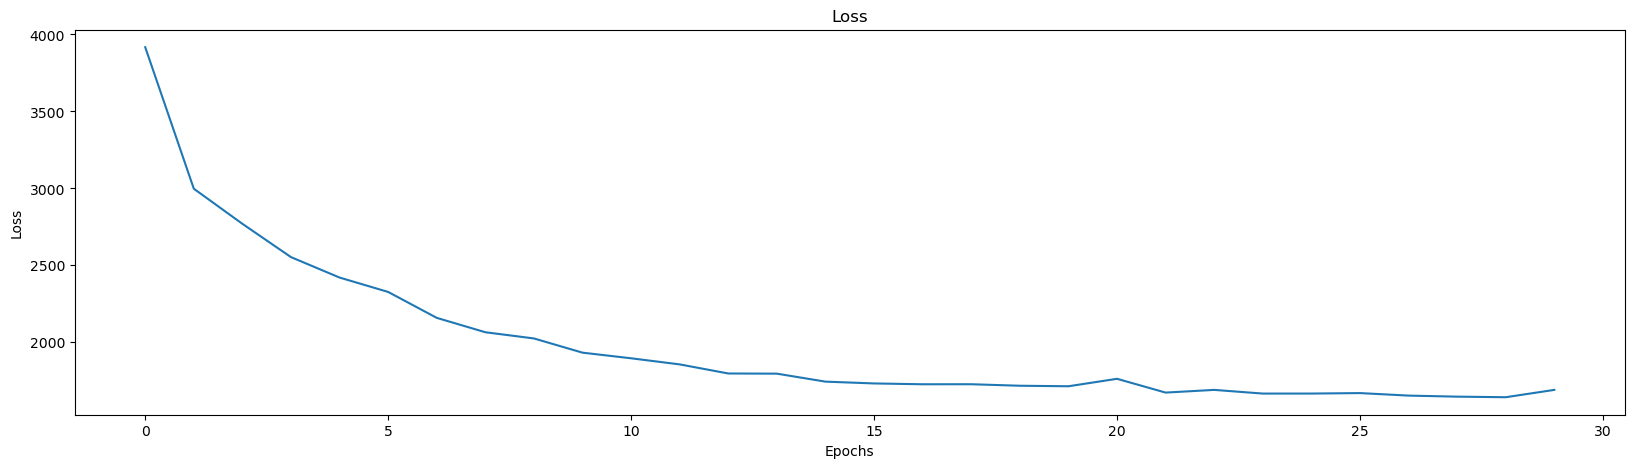

In [47]:
# show loss-epochs graph
step = np.arange(0, num_epochs)

fig, ax = plt.subplots(figsize=(20, 5))

# visualize how loss decrease with epochs
plt.plot(step, np.array(loss_test))
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [48]:
scores.append(r2_score(y_test, model3(X_test_tensor).cpu().detach().numpy().ravel()))
times.append(time.seconds + time.microseconds*1e-6)

In [49]:
print(f'MSE on train: {mean_squared_error(y_train, model3(X_train_tensor).cpu().detach().numpy().ravel())}\n'
      f'MSE on test: {mean_squared_error(y_test, model3(X_test_tensor).cpu().detach().numpy().ravel())}\n'
      f'RMSE on train: {mean_squared_error(y_train, model3(X_train_tensor).cpu().detach().numpy().ravel(), squared=False)}\n'
      f'RMSE on test: {mean_squared_error(y_test, model3(X_test_tensor).cpu().detach().numpy().ravel(), squared=False)}\n'
      f'R2-score on train: {r2_score(y_train, model3(X_train_tensor).cpu().detach().numpy().ravel())}\n'
      f'R2-score on test: {r2_score(y_test, model3(X_test_tensor).cpu().detach().numpy().ravel())}\n')

MSE on train: 935.0283444243283
MSE on test: 1691.0605863560443
RMSE on train: 30.578233180226885
RMSE on test: 41.1225070533892
R2-score on train: 0.8379699664795657
R2-score on test: 0.7093999307162304



In [50]:
# compare predicts with real values
pd.DataFrame({'y_test': y_test, 
              'y_pred': model3(X_test_tensor).cpu().detach().numpy().ravel()})

y_test      y_pred
3145        2   13.879032
12570     191   13.879032
17080     119  118.801575
573        36   13.879032
17080     119  118.957230
...       ...         ...
17080     119  118.953033
10557       4   13.879223
17080     119  118.761101
17254      62   13.899330
17388      31   13.883022

[10131 rows x 2 columns]

This model takes more time than previous and can't be trained better on data that we have.

-------

## Evaluation

-------

We've prepared data and trained 3 different models. The best result was shown by LightGBM: 

In [51]:
gs.best_estimator_

LGBMRegressor(n_jobs=-1, num_leaves=170, random_state=12)

In [52]:
print(f'MSE on train: {mean_squared_error(y_train, gs.best_estimator_.predict(csr_train))}\n'
      f'MSE on test: {mean_squared_error(y_test, gs.best_estimator_.predict(csr_test))}\n'
      f'RMSE on train: {mean_squared_error(y_train, gs.best_estimator_.predict(csr_train), squared=False)}\n'
      f'RMSE on test: {mean_squared_error(y_test, gs.best_estimator_.predict(csr_test), squared=False)}\n'
      f'R2-score on train: {r2_score(y_train, gs.best_estimator_.predict(csr_train))}\n'
      f'R2-score on test: {r2_score(y_test, gs.best_estimator_.predict(csr_test))}\n')

MSE on train: 801.9430835327871
MSE on test: 1439.864955078076
RMSE on train: 28.31859960401974
RMSE on test: 37.9455525072185
R2-score on train: 0.8610321649807335
R2-score on test: 0.7525666087419157



In [53]:
pd.DataFrame({'y_test': y_test, 
              'y_pred': gs.best_estimator_.predict(csr_test)})

y_test      y_pred
3145        2    5.181236
12570     191   13.980892
17080     119  118.956957
573        36    3.462125
17080     119  118.956957
...       ...         ...
17080     119  118.956957
10557       4    9.626062
17080     119  118.956957
17254      62   28.475788
17388      31   27.454415

[10131 rows x 2 columns]

We see that the model predicts the number of cases in the outbreak with some error. But in general, it is clear that the model can answer the question whether there were many or few patients.

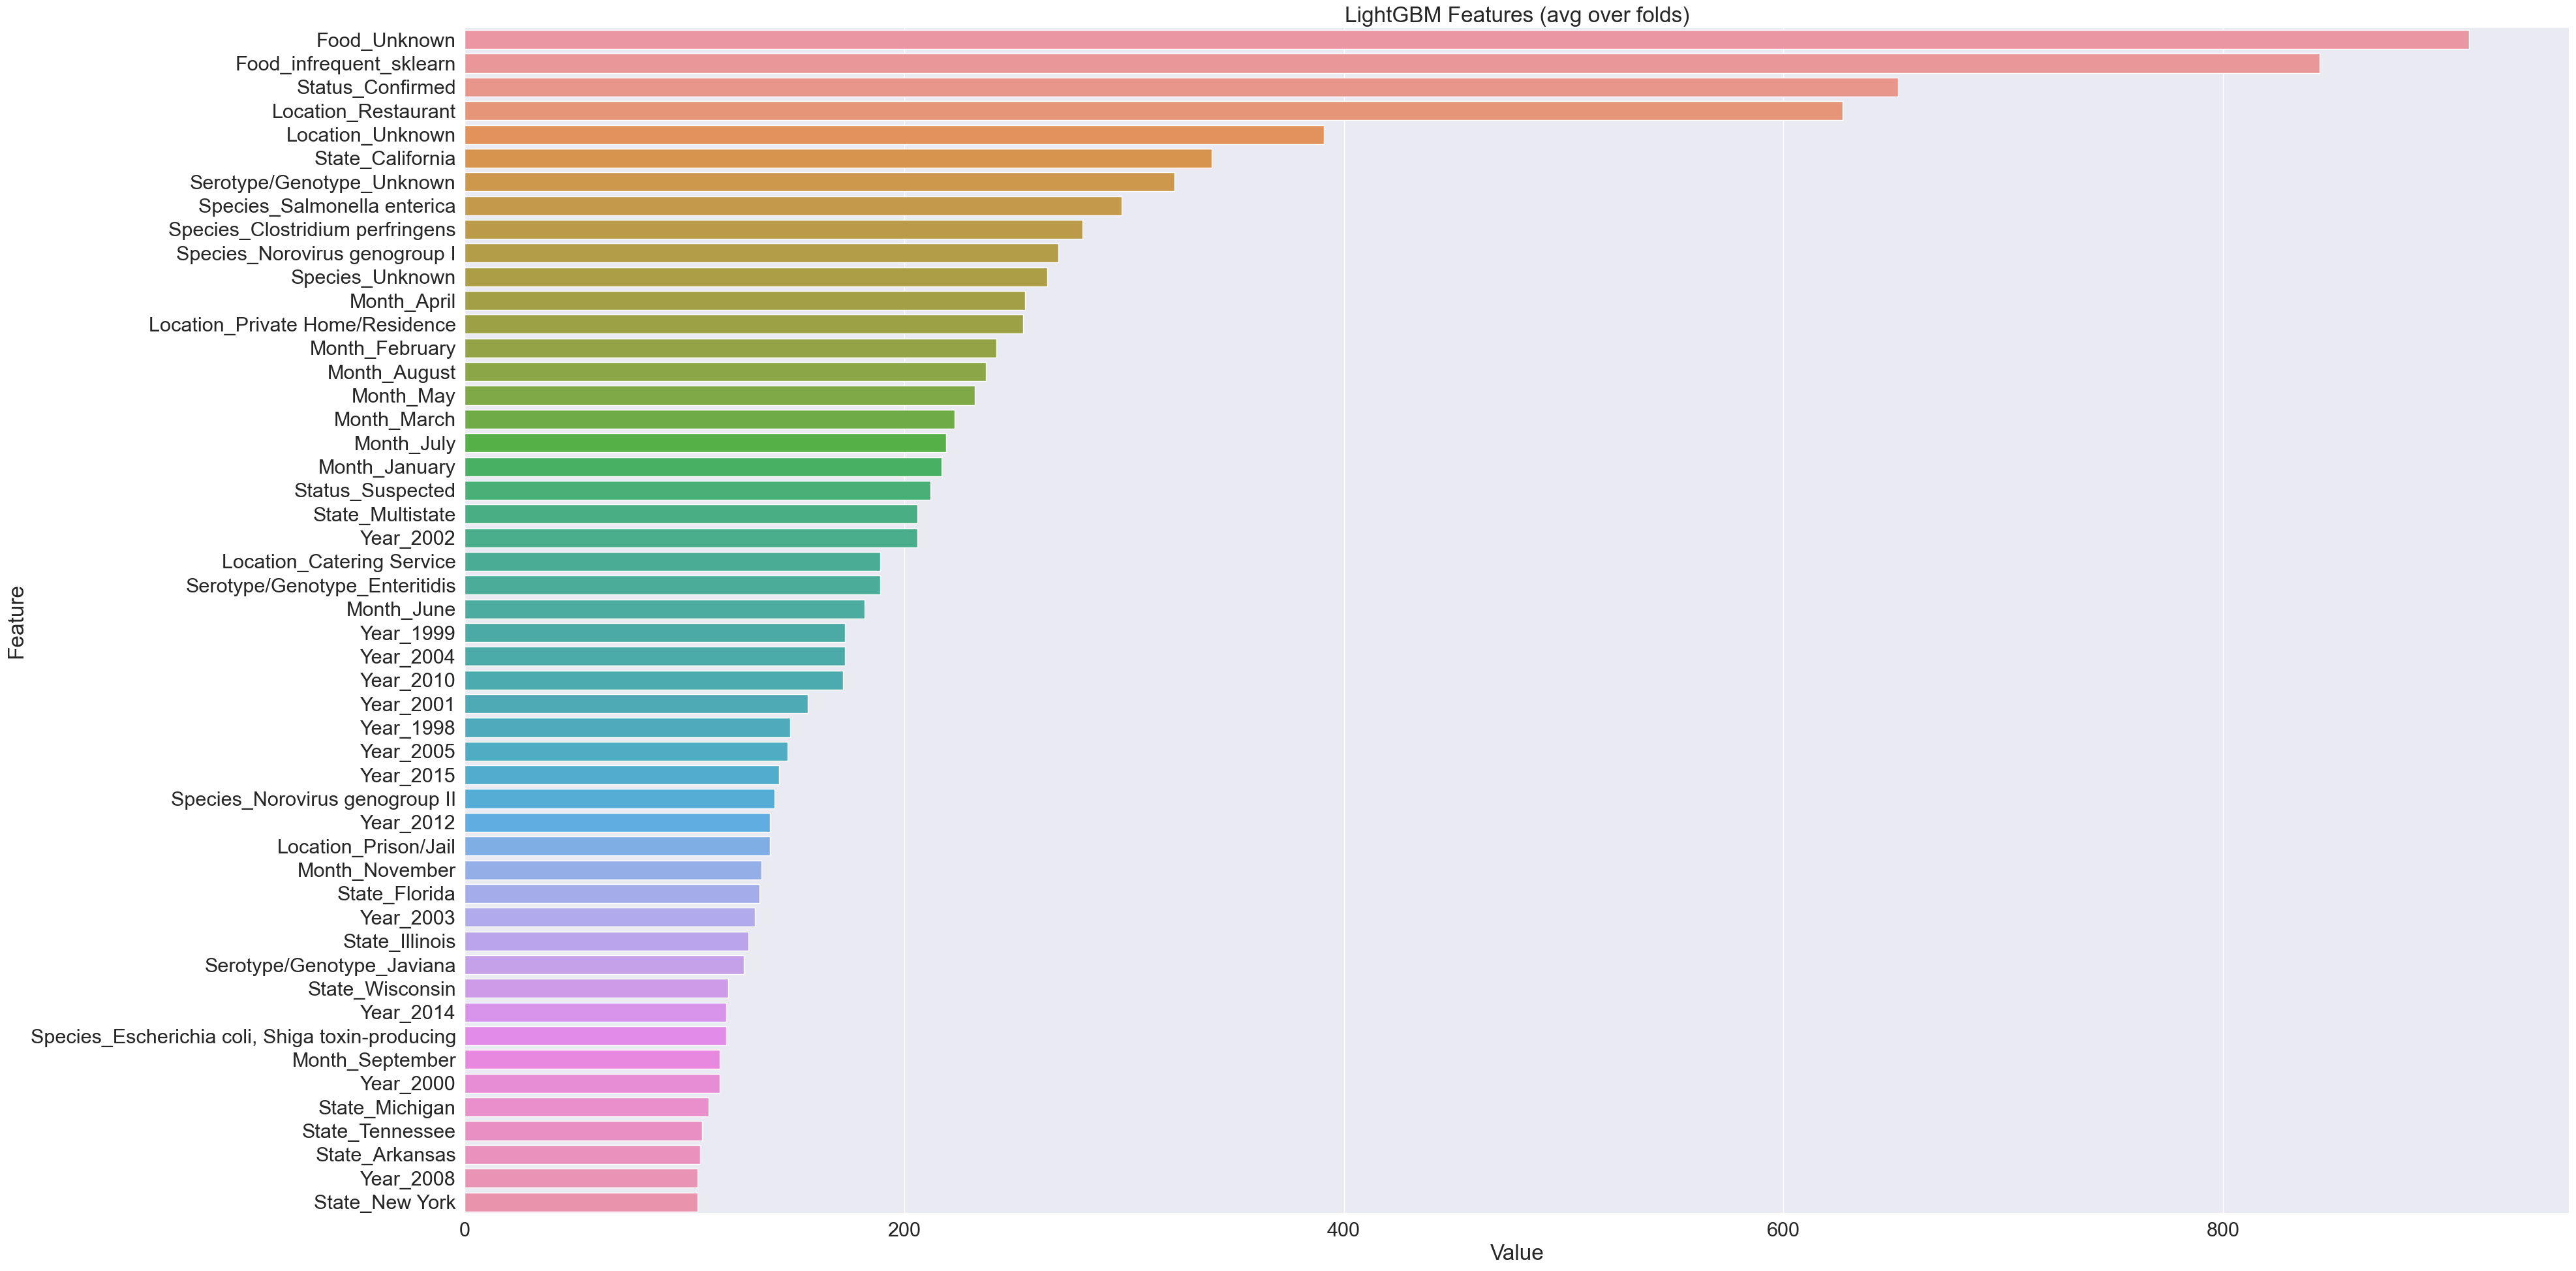

In [54]:
feature_imp = pd.DataFrame({'Value': gs.best_estimator_.feature_importances_,
                            'Feature': X_test.columns})

plt.figure(figsize=(40, 20))
sns.set(font_scale=2)
sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False)[0:50])
plt.title('LightGBM Features (avg over folds)')
plt.savefig('pictures/fig_1.png')
plt.tight_layout()
plt.show();

On the diagram we see which signs have the most influence on the number of diseases. It turns out that two food-related traits have the greatest impact: Food_Unknown and Food_infrequent_sklearn which means rare types of food.

Then if Status = Confirmed it also increases Illnesses. Next we list other values that causes a lot Illnesses:
* Location = Restaurant or Unknown
* State = California
* Serotype/Genotype = Unknown
* Species = Salmonella enterica or Clostridium perfringens or Norovirus genogroup I

This is an interesting information for further research.

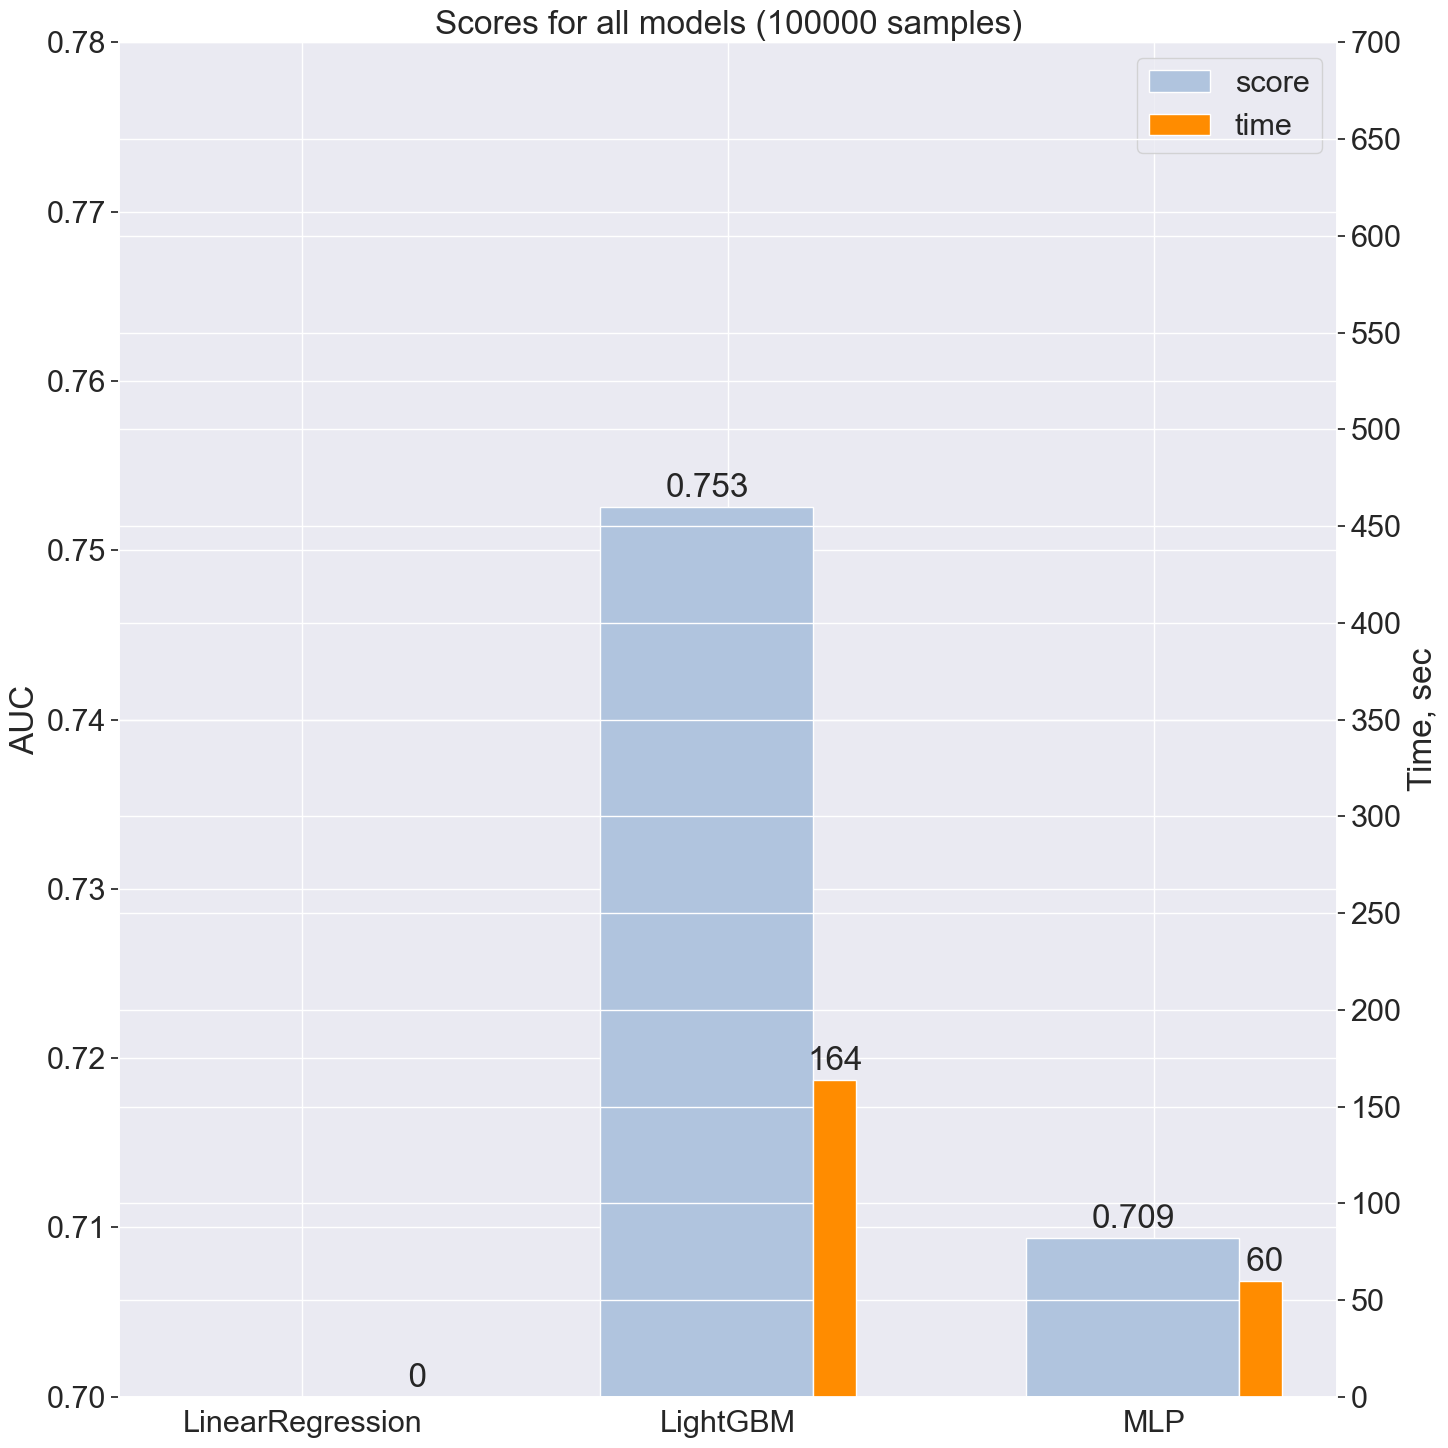

In [61]:
labels = ['LinearRegression', 'LightGBM', 'MLP']
score = scores
time = times

x = np.arange(len(labels))
width = 0.5

fig, ax = plt.subplots(figsize=(15, 15))
ax2 = ax.twinx()
rects1 = ax.bar(x - width/2, score, width, label='score', color='lightsteelblue')
rects2 = ax2.bar(x + width/10, time, width/5, label='time', color='darkorange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Scores for all models (100000 samples)')
ax.set_xticks(x - width/2.5)
ax.set_xticklabels(labels)
ax.set_ylabel('AUC')
ax.set_yticks(np.arange(0.7, 0.78, 0.01))
ax.set_ylim([0.7, 0.78])
ax.legend(handles=[rects1, rects2])
ax2.set_ylabel('Time, sec')
ax2.set_yticks(np.arange(0, 750, 50))
ax2.set_ylim([0, 700])

for rect in rects1:
    height = rect.get_height()
    ax.annotate('{}'.format(f'{height:0.3f}'), 
                xy=(rect.get_x() + rect.get_width() / 2, height), 
                xytext=(0, 2), textcoords='offset points', 
                ha='center', va='bottom')
    
for rect in rects2:
    height = rect.get_height()
    ax2.annotate('{}'.format(f'{height:3.0f}'), 
                xy=(rect.get_x() + rect.get_width() / 2, height), 
                xytext=(0, 2), textcoords='offset points', 
                ha='center', va='bottom')

fig.tight_layout()
plt.savefig('pictures/fig_2.png')
plt.show();

The training time of a linear regression model is so short that it cannot be displayed at this scale. For other models, we observe that LightGBM tooks more time but trained better than MLP.

----------------

## Saving

----------------

In [62]:
# save best model
time = datetime.now()
with open(f'data/model/lgb_{time.strftime("%Y%m%d%H%M")}.pkl', 'wb') as file:
    dill.dump({
        'model': gs.best_estimator_,
        'onehotencoder': ohe,
        'metadata': {
            'Author': 'Vladimir Bocharov',
            'Version': '1.0',
            'Date': time.strftime("%Y.%m.%d_%H:%M")
        }
    }, file)